In [1]:
import os
import sys

# Changes the current path to find the source files
current_dir = os.getcwd()
while current_dir != os.path.abspath("../src"):
    os.chdir("..")
    current_dir = os.getcwd()
sys.path.append(os.path.abspath("Efficient-Computing/Detection/Gold-YOLO"))

In [2]:
from layers import YOLOv8Backbone
from ultralytics.models.yolo.model import YOLO

# yolo_model = YOLO()

# model = YOLOv8Backbone("m", 5)

# model.load_from_yolo_original(first_conv="average")
# model.load_from_real_state()
        
# model.save_real_state()

In [4]:
from ultralytics import YOLO
import cv2

# Load a model
model = YOLO('yolov8n.pt')  # load an official model

# Predict with the model
results = model.predict(source="https://ultralytics.com/images/bus.jpg")
    
print(results)

# Visualize the detection
img = results[0].plot()  # This plots the detections on the image

# Convert BGR to RGB (OpenCV uses BGR by default)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.imwrite("test_image.jpg", img_rgb) 


Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /home/alexandre/Documents/tree-segmentation/src/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 43.4ms
Speed: 2.1ms preprocess, 43.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39

True

In [5]:
from layers import AMF_GD_YOLOv8
from PIL import Image
import torchvision.transforms as transforms
import torch

model = AMF_GD_YOLOv8(3, 1, scale="n", number_classes=4)

# rgb_image_path = "../src/runs/detect/train/zidane.jpg"
rgb_image_path = "../data/images_cropped/2023_122000_484000_RGB_hrl/2023_122000_484000_RGB_hrl_0_1.tif"
chm_image_path = "../data/CHM_cropped_0p24/122000_484000/122000_484000_0_1_filtered_chm.tif"

def preprocess_image(image_path: str) -> torch.Tensor:
    model_input_size = 640
    resize_transform = transforms.Resize((model_input_size, model_input_size))
    to_tensor_transform = transforms.ToTensor()
    
    image = Image.open(image_path)
    resized_image = resize_transform(image)
    tensor = to_tensor_transform(resized_image)
    return tensor

rgb_image_tensor = preprocess_image(rgb_image_path).unsqueeze(0)
chm_image_tensor = preprocess_image(chm_image_path).unsqueeze(0)

output = model(rgb_image_tensor, chm_image_tensor)

In [6]:
from ultralytics.utils import ops
from ultralytics.engine.results import Results

class_names = {
        0: "Tree",
        1: "Tree_disappeared",
        2: "Tree_replaced",
        3: "Tree_new"
    }
orig_imgs = rgb_image_tensor
preds = ops.non_max_suppression(output[0])
if not isinstance(orig_imgs, list):  # input images are a torch.Tensor, not a list
    orig_imgs = ops.convert_torch2numpy_batch(orig_imgs)

results = []
for i, pred in enumerate(preds):
    orig_img = orig_imgs[i]
    pred[:, :4] = ops.scale_boxes((80, 80), pred[:, :4], orig_img.shape)
    # img_path = self.batch[0][i]
    results.append(Results(orig_img, path=rgb_image_path, names=class_names, boxes=pred))


img = results[0].plot()  # This plots the detections on the image

# Convert BGR to RGB (OpenCV uses BGR by default)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.imwrite("test_image.jpg", img_rgb) 

True

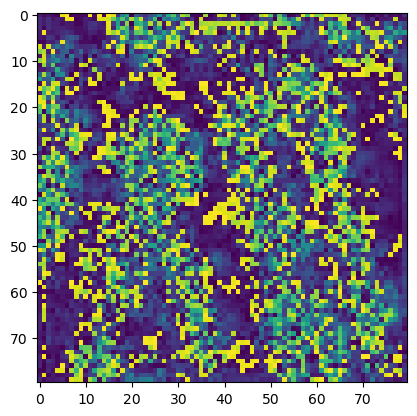

In [7]:
import matplotlib.pyplot as plt

channel = 27

# Normalize the tensor to [0, 255] and convert to uint8
tensor = output[1][0][0, channel:channel+1].permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
tensor = (tensor * 255).byte()  # Scale to [0, 255] and convert to byte

# Display the image
plt.imshow(tensor)
plt.show()

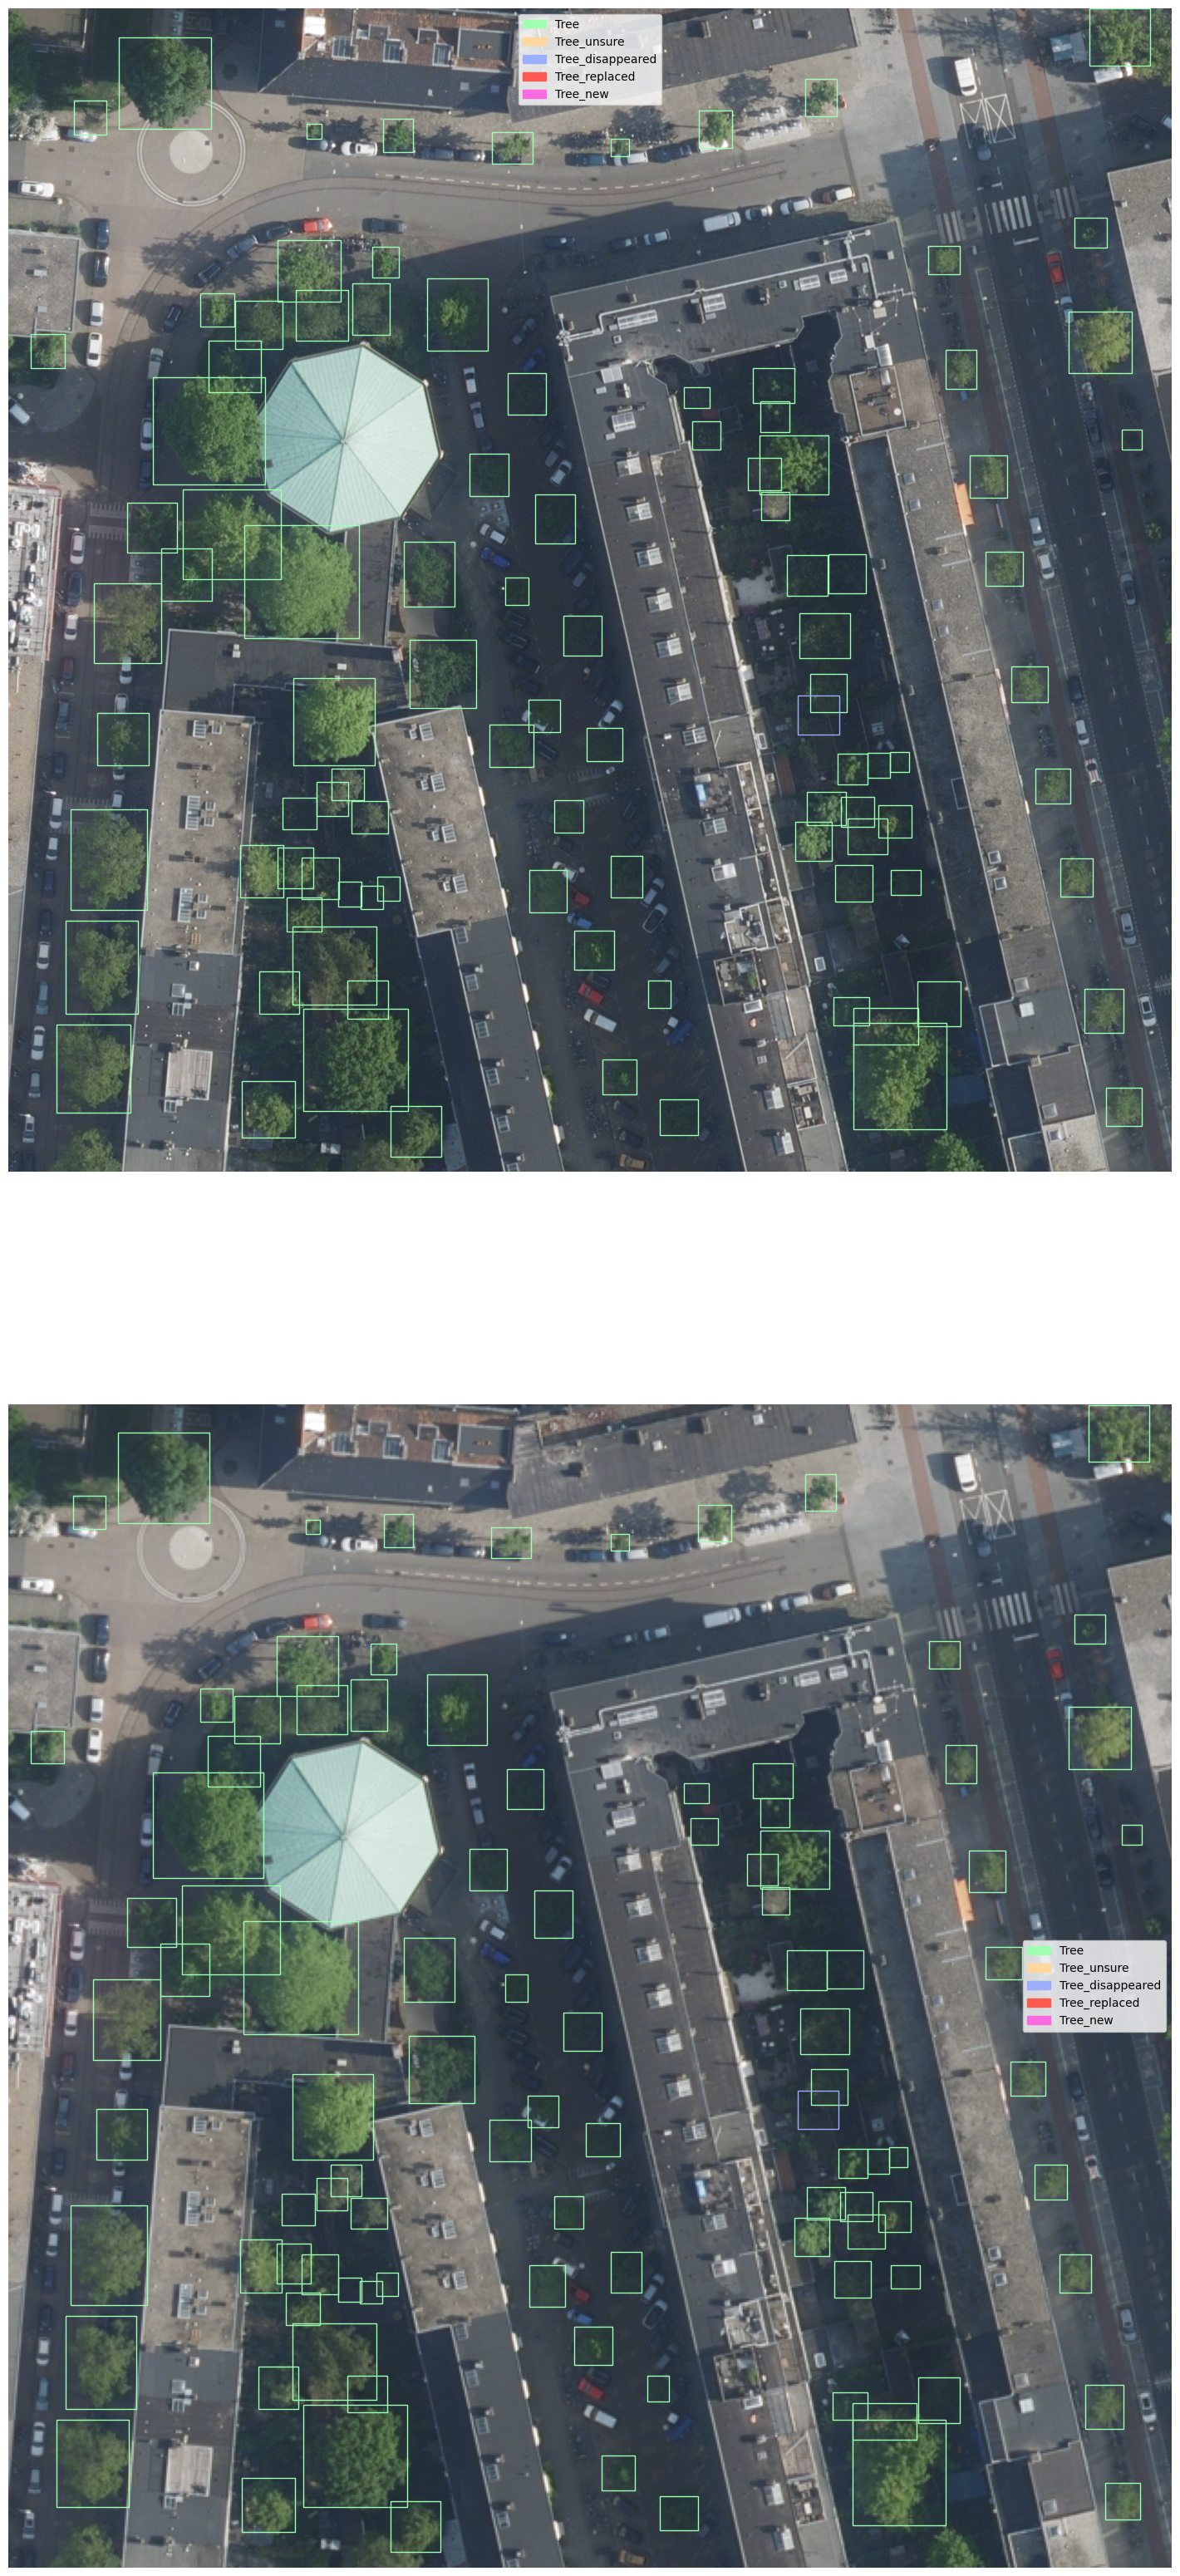

In [8]:
from matplotlib.patches import Rectangle
import json

# Define tile size and OVERLAP
TILE_SIZE = 1920  # Size of each tile
OVERLAP = 480  # Overlap between tiles

def display_image_with_boxes(image_path: str, boxes: list | None=None) -> None:
    reduction_ratio = 3
    
    # Load image
    image = Image.open(image_path)
    image_smaller = Image.open(image_path)
    image_smaller.thumbnail((TILE_SIZE//reduction_ratio, TILE_SIZE//reduction_ratio))

    # Create figure and axis
    fig, axs = plt.subplots(2, 1, figsize=(20, 40))
    
    # Display image
    axs[0].imshow(image)
    axs[1].imshow(image_smaller)
    
    # Annotation colors
    colors = {
        "Tree": "#9effb1",
        "Tree_unsure": "#ffd79e",
        "Tree_disappeared": "#9eaeff",
        "Tree_replaced": "#ff5a52",
        "Tree_new": "#fb6ae1"
    }
    
    # Add bounding boxes if provided
    if boxes:
        for box in boxes:
            # Extract box coordinates
            x, y, width, height, label = box
            # Create a Rectangle patch
            rect = Rectangle((x, y), width, height, linewidth=1, edgecolor=colors[label], facecolor='none')
            # Add the patch to the Axes
            axs[0].add_patch(rect)
            # Create a Rectangle patch
            rect = Rectangle((x//reduction_ratio, y//reduction_ratio), width//reduction_ratio, height//reduction_ratio, linewidth=1, edgecolor=colors[label], facecolor='none')
            # Add the patch to the Axes
            axs[1].add_patch(rect)
    
    # Add each rectangle to the legend individually
    for label, color in colors.items():
        axs[0].add_patch(Rectangle((0,0), 0, 0, color=color, label=label))
        axs[1].add_patch(Rectangle((0,0), 0, 0, color=color, label=label))
    
    axs[0].set_axis_off()
    axs[0].legend()
    axs[1].set_axis_off()
    axs[1].legend()
    
    # Show plot
    plt.show()
    
def get_bounding_boxes(bboxes_path: str) -> list:
    with open(bboxes_path, "r") as file:
        # Load the annotation data
        bboxes_json = json.load(file)
        
        # Get every bounding box
        bboxes = []
        for bbox in bboxes_json["bounding_boxes"]:
            bboxes.append((bbox["x"], bbox["y"], bbox["width"], bbox["height"], bbox["label"]))
            
    return bboxes

image_path = "../data/images_cropped/2023_122000_484000_RGB_hrl/2023_122000_484000_RGB_hrl_0_1.tif"
bboxes_path = "../data/annotations_cropped/2023_122000_484000_RGB_hrl/2023_122000_484000_RGB_hrl_0_1.json"

bboxes = get_bounding_boxes(bboxes_path)
display_image_with_boxes(image_path, bboxes)